In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.llamma import LLAMMA
import matplotlib.pyplot as plt

In [3]:
class Oracle():
    def __init__(self):
        pass
    def price(self):
        return 1490

llamma = LLAMMA(100, 1500, Oracle(), 0)

In [4]:
n0 = llamma.active_band
llamma.deposit('Bob', 1000, n0+1, n0 + 8)
llamma.deposit('Alice', 767, n0+1, n0 + 3)

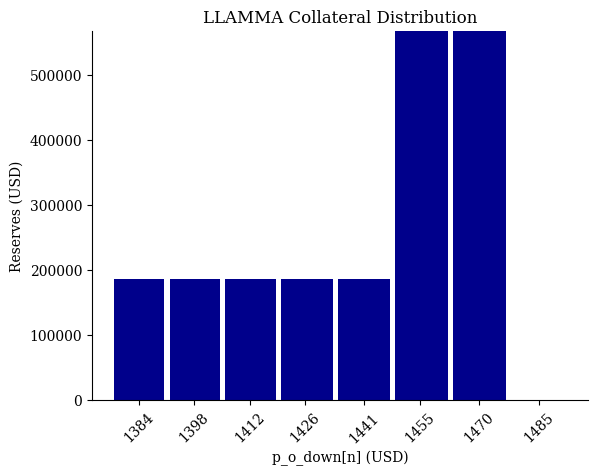

In [5]:
llamma.plot_reserves()

In [6]:
out_x, out_y = llamma.withdraw('Bob', 0.7)

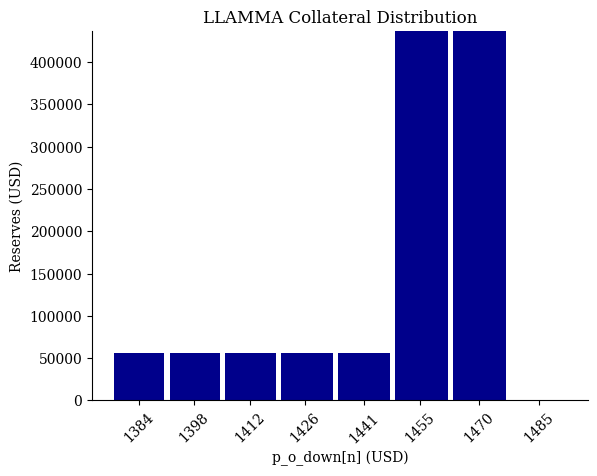

In [7]:
llamma.plot_reserves()

In [12]:
s = llamma._swap(500000, y_in=False)
s

Swap(
in_amount=500000
 out_amount=330.4287734646301
reserves=defaultdict(<function Swap.__init__.<locals>.<lambda> at 0x102374900>, {0: [0.0, 0.0], 1: [500000, 50.2378932020365]})
admin_fee=0
n1=0
n2=1)

In [13]:
llamma.swap(500000, y_in=False)

(500000, 330.4287734646301)

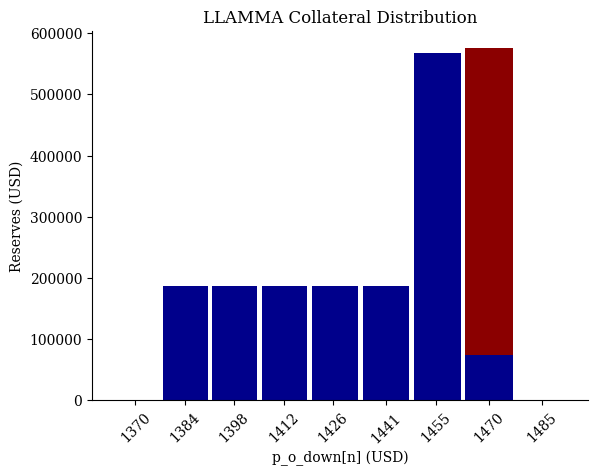

In [14]:
llamma.plot_reserves()